In [27]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

## Finite Difference Methods: Introduction

These numerical methods are designed for finding numerical solutions of differential equations. Here, __we will work with a mesh representing the stock price/time space.__

Thses methods are very useful coping with contracts over a low number of underlyings and __is the method to use if you have a contract with embedded decisions.__

We are going to see how to approximate derivatives using a grid and then how to write the Black-Scholes equation as a difference equation using this grid. 


## Grids

Our grid, representing the price/time space is going to be divided in nodes, each of these nodes containing the corresponding derivative value. 

these nodes are spaced at equal time intervals and at equal intervals in $log(S)$

## Differentiation notation using the grid

The time-step will be $\delta t$ and the asset step will be $\delta S$, both of which are constant. thus the grid is made up of the point at asset values

$$S = i\delta S$$

and times

$$t = T - k\delta t$$

where $0 \leq i \leq I$, and $0 \leq k \leq K$. This means that we will be solving for the asset value going from zero up to the asset value $I\delta S$, tipically this upper value is our approximation to infinity (in this case three or four times exercise value).

We will write the option value at each of the grid points as: 

$$V_i^k = V(i\delta S, T - k\delta t)$$

- <u>Goal:</u> Suppose that we know the option value at each of the grid points, we will use this information to find the derivatives of the option value with respect to $S$ and $t$? That is, __can we find the terms that go into the Black-Scholes equation__?

## Step 1: Approximating $\Theta$

The definition of the first time derivative of $V$ is simply

$$\frac{\partial V}{\partial t} = \lim_{{h \to 0}} \frac{{V(S_t, t + h) - V(S_t, t)}}{{h}}$$

Which is in our notation, 

$$\frac{\partial V}{\partial t} (S, t) \approx \frac{V_i^{k} - V_i^{k+1}}{\delta t}$$

The error in this approximation is $\mathcal{O}(\delta t)$. 

There are other ways of approximating the time derivative of the option value, but thisone will do it for now. 

## Step 2: Approximating $\Delta$

Here we will use the same idea. We can have several choices for this.

We will use the __central difference approximation__

$$\frac{\partial V}{\partial S} (S, t) \approx \frac{V_{i+1}^{k} - V_{i - 1}^{k}}{2\delta S}$$

## Step 3: Approximating $\Gamma$

The gamma of an option is the second derivative of the option with respect to the underlying. The natural approximation for this is: 

$$\frac{\partial ^2 V}{\partial S ^2} (S, t) \approx \frac{V_{i+1}^{k} - 2V_{i+1}^{k}+V_{i - 1}^{k}}{\delta S^2}$$

## Step 4: All together

In terms of the greeks, the Black-Scholes equation can be written as: 

$$\Theta = - \frac{1}{2}\sigma^2S^2\Gamma - rS\Delta + rV$$

$$\frac{\partial V}{\partial t} (S, t) \approx \frac{V_i^{k} - V_i^{k+1}}{\delta t}$$

So, we have: 

$$V_i^{k} = V_i^{k - 1} - \Theta dt $$


## Example: The whole mesh for American/European Option

In [25]:
def European_3D_Vanilla_Option_Value(Vol, Risk_Free_Rate, OptionType, Strike, Expiration, EType, DividendYield, NAS):
    """
    This method will compute all different prices on finite difference grid, going 
    from nowadays (last timestep going backwards) to maturity (k = 0).

    :param Vol: Constant Volatility
    :param Risk_Free_Rate: Constant risk free rate
    :param OptionType: European Call or Put
    :param Strike: Strike option price
    :param Expiration: How far is marturity from now
    :param EType: American ("Y") or European Option
    :param NAS: Number of asset steps
    :param DividendYield: Yield of dividend in  the stock

    :return: Array representing the grid of explicit finite-difference method.
    """

    # Step 1: Defining the variables that will be used.
    dS = 2 * Strike / NAS  # How far we will go in terms of asset prices considered (in this case twice the strike).
    dt = .9 / (Vol ** 2 + NAS ** 2)  # Defining the time-step (this choice is due to algorithm stability).
    NTS = int(Expiration / dt) + 1
    dt = Expiration / NTS  # Ensuring that expiration is an integer number of defined timesteps.
    V = np.zeros((NAS + 1, NTS + 1))
    S = np.ones((NAS + 1))
    Payoff = S.copy()
    if OptionType == "P":
        q = -1
    else:
        q = 1
    # Step 2: Initializing grid values at k = 0 (at expiry). This would be the contract's payoff.
    for i in range(NAS + 1):
        S[i] = i * dS
        V[i, 0] = max(q * (S[i] - Strike), 0)  # Remember that we are going backwards. K=0 corresponds to expiry.
        Payoff[i] = V[i, 0]

    # Now we fill the interior of the grid.
    # Time loop.
    for k in range(1, NTS+1):
        # Asset Loop
        for i in range(1, NAS):
            Delta = (V[i + 1, k - 1] - V[i - 1, k - 1]) / (2 * dS)
            Gamma = (V[i + 1, k - 1] - 2 * V[i, k - 1] + V[i - 1, k - 1]) / (dS ** 2)
            Theta = -(1 / 2) * Vol ** 2 * S[i] ** 2 * Gamma - (Risk_Free_Rate - DividendYield) * S[
                i] * Delta + Risk_Free_Rate * V[
                        i, k - 1]
            V[i, k] = V[i, k - 1] - dt * Theta
        if OptionType == "C":
            V[0, k] = 0
        else:
            V[0, k] = Strike * math.exp(-Risk_Free_Rate * k * dt)
        V[NAS, k] = 2 * V[NAS - 1, k] - V[NAS - 2, k]
        if EType == "Y":
            for i in range(NAS + 1):
                V[i, k] = max(Payoff[i], V[i, k])

    return S, np.around(V, decimals=3)

In [35]:
def European_2D_Vanilla_Option_Value(Vol, Risk_Free_Rate, OptionType, Strike, Expiration, EType, DividendYield, NAS):
    # Step 1: Defining the variables that will be used.
    dS = 2 * Strike / NAS  # How far we will go in terms of asset prices considered (in this case twice the strike).
    dt = .9 / (Vol ** 2 + NAS ** 2)  # Defining the time-step (this choice is due to algorithm stability).
    NTS = int(Expiration / dt) + 1
    dt = Expiration / NTS  # Ensuring that expiration is an integer number of defined timesteps.
    VOld = np.zeros((NAS + 1))
    VNew = VOld.copy()
    S = np.ones((NAS + 1))
    Payoff = S.copy()
    Delta_Final = S.copy()
    Gamma_Final = S.copy()
    Theta_Final = S.copy()
    output_df = pd.DataFrame()

    if OptionType == "P":
        q = -1
    else:
        q = 1
    # Step 2: Initializing grid values at k = 0 (at expiry). This would be the contract's payoff.
    for i in range(NAS + 1):
        # This will be the first column (or even the index column) of out output dataframe.
        S[i] = i * dS
        VOld[i] = max(q * (S[i] - Strike), 0)  # Remember that we are going backwards. K=0 corresponds to expiry.
        # Payoff will be the second column. Next columns will be today's option value and Greeks.
        Payoff[i] = VOld[i]

    # Now we fill the interior of the grid.
    # Time loop.
    for k in range(1, NTS):
        # Asset Loop
        for i in range(1, NAS):
            Delta = (VOld[i + 1] - VOld[i - 1]) / (2 * dS)
            Gamma = (VOld[i + 1] - 2 * VOld[i] + VOld[i - 1]) / (dS ** 2)
            Theta = -(1 / 2) * Vol ** 2 * S[i] ** 2 * Gamma - (Risk_Free_Rate - DividendYield) * S[
                i] * Delta + Risk_Free_Rate * VOld[
                        i]
            VNew[i] = VOld[i] - dt * Theta
            # Now that the interior of the grid is filled we must fill boundaries. 
        if OptionType == "C":
            VNew[0] = 0
        else:
            VNew[0] = Strike * math.exp(-Risk_Free_Rate * k * dt)
        VNew[NAS] = 2 * VNew[NAS - 1] - VNew[NAS - 2]
        VOld = VNew.copy()
        if EType == "Y":
            for i in range(NAS + 1):
                VOld[i] = max(Payoff[i], VOld[i])
    for i in range(1, NAS):
        # We only save all greeks values when we are at today's date.
        Delta_Final[i] = (VOld[i + 1] - VOld[i - 1]) / (2 * dS)
        Gamma_Final[i] = (VOld[i + 1] - 2 * VOld[i] + VOld[i - 1]) / (dS ** 2)
        Theta_Final[i] = -(1 / 2) * Vol ** 2 * S[i] ** 2 * Gamma_Final[i] - (Risk_Free_Rate - DividendYield) * S[i] * \
                         Delta_Final[i] + \
                         Risk_Free_Rate * VOld[i]
    # For computing greeks on boundaries we will use forward and bacwards differences instead of central one.
    Delta_Final[0] = (VOld[1] - VOld[0]) / dS
    Delta_Final[NAS] = (VOld[NAS] - VOld[NAS - 1]) / dS
    # For very high and almost null values of the stock value is almost lineal.
    Gamma_Final[0] = 0
    Gamma_Final[NAS] = 0
    Theta_Final[0] = Risk_Free_Rate * VOld[0]
    Theta_Final[NAS] = -(1 / 2) * Vol ** 2 * S[NAS] ** 2 * Gamma_Final[i] - (Risk_Free_Rate - DividendYield) * S[NAS] * \
                       Delta_Final[i] + \
                       Risk_Free_Rate * VOld[NAS]
    # Let us fill the output dataframe.
    output_df["Stock Price"] = S
    output_df["Payoff"] = Payoff
    output_df["Option's Value"] = VOld
    output_df["Delta"] = Delta_Final
    output_df["Gamma"] = Gamma_Final
    output_df["Theta"] = Theta_Final
    return output_df


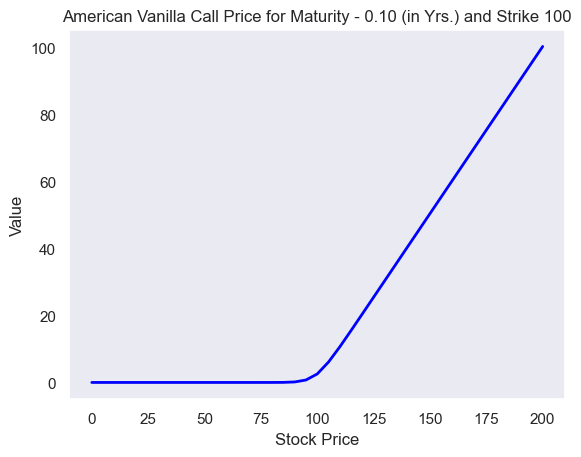

In [36]:
sigma = 0.2
ir = .005
strike = 100
T = 0.1
formatted_T = "{:.2f}".format(T) 
OptionType = "C"
EType = "Y"
stock_prices, V = European_3D_Vanilla_Option_Value(0.2,0.05, "C", strike, T, EType, 0, 40)
if EType == "Y":
    EType = "American"
else: 
    EType = "European"
if OptionType == "C":
    OptionType = "Call"
else:
    OptionType = "Put"

x = stock_prices
y = V[:, -1]

sns.set(style="darkgrid")

# Create the line plot
plt.plot(x, y, color="blue", linewidth=2)

# Customize the plot
plt.xlabel("Stock Price")
plt.ylabel("Value")
plt.title(f"{EType} Vanilla {OptionType} Price for Maturity - {formatted_T} (in Yrs.) and Strike {strike}")


plt.grid(False)

# Display the plot
plt.show()

In [ ]:
def Barrier_Option_Value(Asset, Strike, Expiration, Vol, Risk_Free_Rate, DividendYield, OptionType, Barrier, NAS, EType = "N"):
    """
    Output the value of a Barrier Option. In our case a down-and-out call option.

    :param Asset: Current Asset's Price
    :param Strike: Strike of the option
    :param Expiration: Time to Maturity
    :param Vol: Constant volatility term
    :param Risk_Free_Rate:
    :param DividendYield: Dividend Yield on this option
    :param OptionType: C or P for Call or Put
    :param Barrier: Barrier Value (If the option touches the barrier it becomes worthless)
    :param NAS: Number of Asset Steps
    :param EType: Early Exercise or not.

    :return: Value of the exotic option.
    """
    dS = 2 * Strike / NAS  # How far we will go in terms of asset prices considered (in this case twice the strike).
    NearestGridPt = int((Asset - Barrier)/dS) # Defining the number of steps between Asset Level and the closest
    # point to the barrier.
    dummy = ((Asset - Barrier) - NearestGridPt*dS)/dS
    dt = .9 / (Vol ** 2 + NAS ** 2)  # Defining the time-step (this choice is due to algorithm stability).
    NTS = int(Expiration / dt) + 1
    dt = Expiration / NTS  # Ensuring that expiration is an integer number of defined timesteps.
    VOld = np.zeros((NAS + 1))
    VNew = VOld.copy()
    S = np.ones((NAS + 1))
    Payoff = S.copy()

    if OptionType == "P":
        q = -1
    else:
        q = 1
    # Step 2: Initializing grid values at k = 0 (at expiry). This would be the contract's payoff.
    for i in range(NAS + 1):
        # This will be the first column (or even the index column) of out output dataframe.
        S[i] = Barrier + i * dS
        VOld[i] = max(q * (S[i] - Strike), 0)  # Remember that we are going backwards. K=0 corresponds to expiry.
        # Payoff will be the second column. Next columns will be today's option value and Greeks.
        Payoff[i] = VOld[i]

    # Now we fill the interior of the grid.
    # Time loop.
    for k in range(1, NTS):
        # Asset Loop
        for i in range(1, NAS):
            Delta = (VOld[i + 1] - VOld[i - 1]) / (2 * dS)
            Gamma = (VOld[i + 1] - 2 * VOld[i] + VOld[i - 1]) / (dS ** 2)
            Theta = -(1 / 2) * Vol ** 2 * S[i] ** 2 * Gamma - (Risk_Free_Rate - DividendYield) * S[
                i] * Delta + Risk_Free_Rate * VOld[
                        i]
            VNew[i] = VOld[i] - dt * Theta
        # Now that the interior of the grid is filled we must fill boundaries.
        #In a barrier, value of the option is 0.
        VNew[0] = 0
        VNew[NAS] = 2 * VNew[NAS - 1] - VNew[NAS - 2]
        VOld = VNew.copy()
        if EType == "Y":
            for i in range(NAS + 1):
                VOld[i] = max(Payoff[i], VOld[i])
    BarrierValue = (1 - dummy)*VOld[NearestGridPt - 1] + dummy*VOld[NearestGridPt]
    return BarrierValue